# Predicting Diesaster Tweets ******
Flatiron School Data Science: Project 4

Advanced Machine Learning Topics **********
- **Author**: Zaid Shoorbajee
- **Instructor**: Morgan Jones
- **Pace**: Flex, 40 weeks

## Overview and Business Understanding
Lorem ipsum
## Data Undersanding
Lorem ipsum
### Dataset and features
Lorem ipsum
### Target variable
Lorem ipsum
### Scoring
Lorem ipsum

In [1]:
import time
start_time = time.time()

In [2]:
import numpy as np
import pandas as pd

from nltk import FreqDist
from nltk.tokenize import \
    regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix, f1_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

from keras import models
from keras import layers
from keras import regularizers
from keras.metrics import Precision, Recall, AUC
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasRegressor

import re
from collections import OrderedDict, defaultdict, Counter
import itertools
import string

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.options.display.max_colwidth = 150
seed = 7

In [3]:
# Need to revise headers


## Data Preparation

In [4]:
# Loading and previewing the dataset

df = pd.read_csv('./data/disaster_tweets/train.csv')
df.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires,1
6,10,NaN,NaN,"#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas",1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in the woods...,1
8,14,NaN,NaN,There's an emergency evacuation happening now in the building across the street,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our area...,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
df.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

### Keyword and location columns

The `location` column doesn't have much usable information in some cases it's just nonsense:

In [7]:
print('Sample of some of the location values')
df['location'].unique()[7:17].tolist()

Sample of some of the location values


['World Wide!!',
 'Paranaque City',
 'Live On Webcam',
 'milky way',
 'GREENSBORO,NORTH CAROLINA',
 'England.',
 'Sheffield Township, Ohio',
 'India',
 'Barbados',
 'Anaheim']

Therefore I will not be using this column as a feature.

The `keyword` column shows what was used to search for relevant tweets. I don't plan to use this as a feature in the model, but this column can give use insight as to what kinds of tweets the keywords yield. 

In [8]:
# Counter(df['keyword'])

In [9]:
# `keyword` has 61 missing values
# Filling missing values with 'missing_keyword' so I can visualize.

## df['keyword'] = df['keyword'].fillna('missing_keyword')

In [10]:
# df['keyword_count_0'] = \
#     df['keyword'].apply(
#         lambda x: Counter(df['keyword'][df['target'] == 0])[x]
#         )
# df['keyword_count_1'] = \
#     df['keyword'].apply(
#         lambda x: Counter(df['keyword'][df['target'] == 1])[x]
#         )

In [11]:
# fig, axes = plt.subplots(ncols=2, figsize=(15, 50))

# sns.countplot(
#     y=df[df['target']==0].sort_values(
#         by='keyword_count_0', ascending=False
#         )['keyword'],
#     color='blue',
#     ax=axes[0]
#     )
# sns.countplot(
#     y=df[df['target']==1].sort_values(
#         by='keyword_count_1', ascending=False
#         )['keyword'],
#     color='red',
#     ax=axes[1]
#     )

# axes[0].set_title('Non-disaster tweets')
# axes[1].set_title('Disaster tweets')

# plt.tight_layout()
# plt.show()

### Tweets and Target

The main feature is `text`, which is the full text of the given tweet. Each tweet is labeled in `target` as referring to a disaster (1) or not (0).

Before proceeding, I'll check if there are any tweets that are duplicated.

In [12]:
df['text'].duplicated().sum()

110

There are numerous duplicated tweets, perhaps tweeted by different accounts. The most concerning part of this is that some of these duplicates have contradicting labels:

In [13]:
df[df['text'] == "He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam"]

,id,keyword,location,text,target
3240,4656,engulfed,NaN,He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam,0
3243,4659,engulfed,Kuwait,He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam,1
3248,4669,engulfed,Bahrain,He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam,1
3251,4672,engulfed,NaN,He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam,0
3261,4684,engulfed,NaN,He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam,0
3266,4691,engulfed,NaN,He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam,0


In [14]:
df[df['text'] == ".POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4"]

,id,keyword,location,text,target
2830,4068,displaced,Pedophile hunting ground,.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4,1
2831,4072,displaced,Pedophile hunting ground,.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4,1
2832,4076,displaced,Pedophile hunting ground,.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4,0
2833,4077,displaced,Pedophile hunting ground,.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4,1


In [15]:
df[df['text'] == "Caution: breathing may be hazardous to your health."]

,id,keyword,location,text,target
4232,6012,hazardous,NaN,Caution: breathing may be hazardous to your health.,1
4235,6017,hazardous,NaN,Caution: breathing may be hazardous to your health.,0


In [16]:
df[df['text'] == "like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit"]

,id,keyword,location,text,target
1221,1760,buildings%20burning,dallas,like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit,1
1349,1950,burning%20buildings,dallas,like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit,0


It seems that some of these tweets were labeled sloppily or are difficult to interpret. In any case, having identical tweets labeled differently will cause unwanted noise in the model. Therefore, I'll drop all duplicated tweets, which account for less than 2% of the dataset.

In [17]:
# Proportion of duplicate tweets

df['text'].duplicated().sum() / len(df)

0.0144489688690398

In [18]:
df = df.drop_duplicates('text', keep=False)

#### Separating text from target

In [19]:
tweets = df[['text']]
target = df['target']

In [20]:
print('Distribution of Target')
print()
print(target.value_counts())
print()
print('Normalized:')
print(target.value_counts(normalize=True))

Distribution of Target

0    4284
1    3150
Name: target, dtype: int64

Normalized:
0    0.576271
1    0.423729
Name: target, dtype: float64


About 42% of the tweets have been labeled as actual disaster tweets. This is not a major imbalance, and this I won't need to artificially rebalance the dataset.

### Train-Test Split

In [21]:
# Splitting the full dataset into training and testing data

X_train, X_test, y_train, y_test = train_test_split(
    tweets, target, test_size=.25, random_state=seed
)

# Splitting the training set into training and validation data

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=.25, random_state=seed
)

In [22]:
# Cleaning and tokenizing the tweet text

In [23]:
# Saving a copy of untouched tweets
X_train_tweets_unprocessed = X_train.copy()['text'] 

X_test_tweets_unprocessed = X_test.copy()['text'] 

X_val_tweets_unprocessed = X_val.copy()['text'] 

In [24]:
# Make everything lowercase

X_train['text'] = X_train['text'].apply(lambda x: x.lower())

X_test['text'] = X_test['text'].apply(lambda x: x.lower())

X_val['text'] = X_val['text'].apply(lambda x: x.lower())

<ipython-input-24-f04f0ed93228>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['text'] = X_test['text'].apply(lambda x: x.lower())


In [25]:
X_train.head(10)

,text
7250,death certificates safes weapons and teslas: def con 23 #security http://t.co/kmdqm3nlns
6439,infographic: at least 20 turkish security officials killed in pkk and isis terror attacks since suruc suicide bombing http://t.co/uvaojzcycz
4885,3 years after the sikh temple massacre hate-violence prevention is key | @dviyer @colorlines http://t.co/nlbltynv36 http://t.co/bjrrqhhohl
4115,gotta love #summer in #calgary. #yyc #hailstorm #crazyweather http://t.co/xqbwnlbbiu
575,usa today: .@fedex will no longer to transport bioterror pathogens after ... - http://t.co/iadlslqdpd #newsintweets http://t.co/o8y1sul4ow
2741,@keegan172 i'm devastated
3337,5 dead 3 missing 103 families evacuated due to floods in bukidnon: ... http://t.co/z0hsckvysn
5892,who need friends when there's booze and darude - sandstorm :d
4368,complete solution to get rid of http://t.co/9cntp3nq6o ûò [browser hijacker removal guide]! - http://t.co/qdf6asaelm
5439,now trending in nigeria: police charge traditional ruler others with informantûªs murder http://t.co/93infxzhx0


### Dealing with URLs

Many tweets contain URLs, which, from an NLP standpoint are essentially random strings and thus won't be useful as vectorized tokens. But before I remove them, I will turn the presence of a URL into a binary feature.

In [26]:
def binary_url(text):
    """
    Returns 1 if a string contains a URL, else returns 0.
    """
    search = re.search(pattern=r'http\S+', string=text)
    return int(bool(search))

# Making a series indicating whether the tweet has a URL. I will use this later when extracting more meta-features.

has_url_Series_train = X_train['text'].apply(binary_url).rename('has_url')
has_url_Series_test = X_test['text'].apply(binary_url).rename('has_url')
has_url_Series_val = X_val['text'].apply(binary_url).rename('has_url')

In [27]:
# Removing URLs from all tweets

X_train['text'] = X_train['text'].apply(
    lambda x: re.sub(
        pattern=r'http\S+', repl='', string=x)
        )

X_test['text'] = X_test['text'].apply(
    lambda x: re.sub(
        pattern=r'http\S+', repl='', string=x)
        )

X_val['text'] = X_val['text'].apply(
    lambda x: re.sub(
        pattern=r'http\S+', repl='', string=x)
        )

<ipython-input-27-1182888dafc8>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['text'] = X_test['text'].apply(


### Tokenizing tweets

#### I plan to make multiple tokenized versions of each tweet.
* Basic version: Any word with at least two letters. Strips the symbols for hashtags (#) and mentions(@)
* Basic version, excluding stop words
* Lemmatized version of basic version
* Lemmatized version of basic version, exluding stop words.

In [28]:
example_tweet = X_train['text'].loc[1370]
example_tweet

'ted cruz fires back at jeb &amp; bush: \x89ûïwe lose because of republicans like jeb &amp; mitt.\x89û\x9d [video] -  '

In [29]:
token_pattern = r"[a-zA-Z]+'?[a-zA-Z]+"
# Pattern: Any word with at least two characters, including up to one apostrophe

tokenizer = RegexpTokenizer(token_pattern)

Let's see how well the tokenizer does with the pattern I used above.

In [30]:
print(tokenizer.tokenize(example_tweet))

['ted', 'cruz', 'fires', 'back', 'at', 'jeb', 'amp', 'bush', 'we', 'lose', 'because', 'of', 'republicans', 'like', 'jeb', 'amp', 'mitt', 'video']


That seems to work. However, 'amp' is an artifact of "&amp;", which is the HTML entity for an ampersand ("&").

I will replace any instance of "&amp;" with the word "and" in the original text.

In [31]:
X_train['text'] = X_train['text'].apply(lambda x: re.sub("&amp;", "and", x))

X_test['text'] = X_test['text'].apply(lambda x: re.sub("&amp;", "and", x))

X_val['text'] = X_val['text'].apply(lambda x: re.sub("&amp;", "and", x))

<ipython-input-31-ca8796cea136>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['text'] = X_test['text'].apply(lambda x: re.sub("&amp;", "and", x))


In [32]:
X_train['tokens'] = X_train['text'].apply(tokenizer.tokenize)

X_test['tokens'] = X_test['text'].apply(tokenizer.tokenize)

X_val['tokens'] = X_val['text'].apply(tokenizer.tokenize)

<ipython-input-32-56f77634f04d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['tokens'] = X_test['text'].apply(tokenizer.tokenize)


In [33]:
# Check most common tokens

FreqDist(X_train['tokens'].explode()).most_common(20)

[('the', 1799),
 ('in', 1105),
 ('to', 1101),
 ('of', 999),
 ('and', 958),
 ('is', 532),
 ('for', 489),
 ('on', 475),
 ('you', 416),
 ('my', 388),
 ('that', 325),
 ('it', 309),
 ('at', 295),
 ('by', 282),
 ('with', 276),
 ('this', 269),
 ('from', 238),
 ('be', 230),
 ('was', 213),
 ('have', 208)]

#### All tweets have been tokenized. Now I will make a version without stop words.

To make a comprehensive list of stop words, I will combine the default lists from the NLTK and SpaCy libraries.

In [34]:
sw_spacy = list(nlp.Defaults.stop_words)
sw_nltk = stopwords.words('english')
stopword_list = list(set(sw_spacy + sw_nltk))

In [35]:
X_train['tokens_no_sw'] = \
    X_train['tokens'].apply(
        lambda x: [w for w in x if not w in stopword_list]
    )

X_test['tokens_no_sw'] = \
    X_test['tokens'].apply(
        lambda x: [w for w in x if not w in stopword_list]
    )

X_val['tokens_no_sw'] = \
    X_val['tokens'].apply(
        lambda x: [w for w in x if not w in stopword_list]
    )

<ipython-input-35-df28a31bb606>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['tokens_no_sw'] = \


In [36]:
# Check most common tokens (without stop words)

FreqDist(X_train['tokens_no_sw'].explode()).most_common(20)

[('like', 196),
 ('fire', 144),
 ('news', 131),
 ("i'm", 130),
 ('new', 119),
 ('people', 111),
 ('video', 95),
 ('emergency', 90),
 ('day', 85),
 ('police', 79),
 ('time', 78),
 ('man', 75),
 ('disaster', 74),
 ('rt', 74),
 ('body', 68),
 ('suicide', 65),
 ('love', 65),
 ('know', 65),
 ('youtube', 65),
 ('going', 64)]

"i'm" should also be considered a stop word

In [37]:
stopword_list.extend(["i'm"])

In [38]:
X_train['tokens_no_sw'] = \
    X_train['tokens'].apply(
        lambda x: [w for w in x if not w in stopword_list]
    )

X_test['tokens_no_sw'] = \
    X_test['tokens'].apply(
        lambda x: [w for w in x if not w in stopword_list]
    )

X_val['tokens_no_sw'] = \
    X_val['tokens'].apply(
        lambda x: [w for w in x if not w in stopword_list]
    )

<ipython-input-38-df28a31bb606>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['tokens_no_sw'] = \


In [39]:
# Check most common tokens (without stop words)

top_20_no_sw = FreqDist(X_train['tokens_no_sw'].explode()).most_common(20)
top_20_no_sw

[('like', 196),
 ('fire', 144),
 ('news', 131),
 ('new', 119),
 ('people', 111),
 ('video', 95),
 ('emergency', 90),
 ('day', 85),
 ('police', 79),
 ('time', 78),
 ('man', 75),
 ('disaster', 74),
 ('rt', 74),
 ('body', 68),
 ('suicide', 65),
 ('love', 65),
 ('know', 65),
 ('youtube', 65),
 ('going', 64),
 ('killed', 62)]

Previewing the restulting features:

In [40]:
X_train.head()

,text,tokens,tokens_no_sw
7250,death certificates safes weapons and teslas: def con 23 #security,"[death, certificates, safes, weapons, and, teslas, def, con, security]","[death, certificates, safes, weapons, teslas, def, con, security]"
6439,infographic: at least 20 turkish security officials killed in pkk and isis terror attacks since suruc suicide bombing,"[infographic, at, least, turkish, security, officials, killed, in, pkk, and, isis, terror, attacks, since, suruc, suicide, bombing]","[infographic, turkish, security, officials, killed, pkk, isis, terror, attacks, suruc, suicide, bombing]"
4885,3 years after the sikh temple massacre hate-violence prevention is key | @dviyer @colorlines,"[years, after, the, sikh, temple, massacre, hate, violence, prevention, is, key, dviyer, colorlines]","[years, sikh, temple, massacre, hate, violence, prevention, key, dviyer, colorlines]"
4115,gotta love #summer in #calgary. #yyc #hailstorm #crazyweather,"[gotta, love, summer, in, calgary, yyc, hailstorm, crazyweather]","[gotta, love, summer, calgary, yyc, hailstorm, crazyweather]"
575,usa today: .@fedex will no longer to transport bioterror pathogens after ... - #newsintweets,"[usa, today, fedex, will, no, longer, to, transport, bioterror, pathogens, after, newsintweets]","[usa, today, fedex, longer, transport, bioterror, pathogens, newsintweets]"


### Lemmatizing tweets

Now I want to make a version of these tokenized tweets where each word is lemmatized. **Lemmatization** is _________.

I will the tokenizer I made above, then the SpaCy library's lemmatizer to do this. Essentially I am making my own tokenizing function, where the output is lemmatized tokens instead of just plain tokens.

In [41]:
def spacy_lemmatize(text):
    """
    Uses NLTK and SpaCy to tokenize a string and return the lemma of each token.
    """
    tokens = tokenizer.tokenize(text)
    doc = nlp(' '.join(tokens))
    return [t.lemma_.lower() for t in doc]

In [42]:
# Lemmatized tokens, including stop words

X_train['lemmas'] = X_train['text'].apply(spacy_lemmatize)

X_test['lemmas'] = X_test['text'].apply(spacy_lemmatize)

X_val['lemmas'] = X_val['text'].apply(spacy_lemmatize)

<ipython-input-42-cbdee83a74fa>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['lemmas'] = X_test['text'].apply(spacy_lemmatize)


In [43]:
# Check most common lemmas

FreqDist(X_train['lemmas'].explode()).most_common(20)

[('be', 1904),
 ('the', 1799),
 ('to', 1127),
 ('in', 1105),
 ('of', 999),
 ('and', 959),
 ('for', 489),
 ('you', 477),
 ('on', 475),
 ('not', 451),
 ('have', 435),
 ('it', 427),
 ('i', 426),
 ('my', 388),
 ('that', 359),
 ('do', 349),
 ('at', 295),
 ('by', 282),
 ('with', 276),
 ('this', 269)]

In order to make the lemmatized tokens without stop words, I will also need to lemmatize the stop words.

This has to be done to the stop words while they are still within the string because  SpaCy uses grammatical context to lemmatize.

In [44]:
# Lemmatized version of stop words based on training set

stopword_list_lem = []

sw_lem_Series = \
    X_train['text'].apply(
    lambda x: [t.lemma_.lower() for t in nlp(x) if t.text in stopword_list]
    )

for row in sw_lem_Series:
    stopword_list_lem.extend(row)

stopword_list_lem = list(set(stopword_list_lem))

In [45]:
# Lemmatized tokens, excluding stop words

X_train['lemmas_no_sw'] = X_train['lemmas'].apply(
    lambda x: [l for l in x if l not in stopword_list_lem]
    )

X_test['lemmas_no_sw'] = X_test['lemmas'].apply(
    lambda x: [l for l in x if l not in stopword_list_lem]
    )

X_val['lemmas_no_sw'] = X_val['lemmas'].apply(
    lambda x: [l for l in x if l not in stopword_list_lem]
    )

<ipython-input-45-5b185a7430a4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['lemmas_no_sw'] = X_test['lemmas'].apply(


In [46]:
# Check most common lemmas (without stop words)

FreqDist(X_train['lemmas_no_sw'].explode()).most_common(20)

[('like', 231),
 ('fire', 193),
 ('news', 131),
 ('new', 125),
 ('people', 112),
 ('kill', 104),
 ('day', 101),
 ('video', 99),
 ('man', 95),
 ('time', 95),
 ('attack', 91),
 ('emergency', 91),
 ('come', 91),
 ('year', 89),
 ('bomb', 88),
 ('body', 85),
 ('burn', 83),
 ('crash', 81),
 ('love', 79),
 ('police', 79)]

In [47]:
# VISUALIZE the differences. Count plots or bar charts. Differences between 0 and 1.

# Do anything about the word "like"???

#
# 
# 
# 
# 
#

### More linguistic feature engineering

I will use the SpaCy library to extract more linguistic features from the tweets.

### Vectorized part-of-speech (POS) tags

The SpaCy library is pre-trained to parse through sentences and identify each word's grammatical part-of-speech.

Here are some examples of what the tool can identify:

In [48]:
# POS VISUALIZATIONS
#
# 
# 
# 
# 
# 
#

I plan to use this tool in order to vectorize the parts-of-speech of each tweet.

First, I'll convert each token into a string of its POS tag.

In [49]:
# Spacy POS

def spacy_pos(text):
    """
    Takes in a string and returns a list of part-of-speech tokens.
    """
    tokens = tokenizer.tokenize(text)
    doc = nlp(' '.join(tokens))
    pos_tokens = [t.pos_ for t in doc]
    return pos_tokens

X_train['text_as_POS'] = X_train['text'].apply(spacy_pos)

X_test['text_as_POS'] = X_test['text'].apply(spacy_pos)

X_val['text_as_POS'] = X_val['text'].apply(spacy_pos)

<ipython-input-49-9850555ab4f2>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['text_as_POS'] = X_test['text'].apply(spacy_pos)


In [50]:
X_train.head()

,text,tokens,tokens_no_sw,lemmas,lemmas_no_sw,text_as_POS
7250,death certificates safes weapons and teslas: def con 23 #security,"[death, certificates, safes, weapons, and, teslas, def, con, security]","[death, certificates, safes, weapons, teslas, def, con, security]","[death, certificate, safe, weapon, and, tesla, def, con, security]","[death, certificate, safe, weapon, tesla, def, con, security]","[NOUN, NOUN, VERB, NOUN, CCONJ, NOUN, VERB, NOUN, NOUN]"
6439,infographic: at least 20 turkish security officials killed in pkk and isis terror attacks since suruc suicide bombing,"[infographic, at, least, turkish, security, officials, killed, in, pkk, and, isis, terror, attacks, since, suruc, suicide, bombing]","[infographic, turkish, security, officials, killed, pkk, isis, terror, attacks, suruc, suicide, bombing]","[infographic, at, least, turkish, security, official, kill, in, pkk, and, isis, terror, attack, since, suruc, suicide, bombing]","[infographic, turkish, security, official, kill, pkk, isis, terror, attack, suruc, suicide, bombing]","[PROPN, ADP, ADJ, ADJ, NOUN, NOUN, VERB, ADP, PROPN, CCONJ, NOUN, NOUN, NOUN, SCONJ, NOUN, NOUN, NOUN]"
4885,3 years after the sikh temple massacre hate-violence prevention is key | @dviyer @colorlines,"[years, after, the, sikh, temple, massacre, hate, violence, prevention, is, key, dviyer, colorlines]","[years, sikh, temple, massacre, hate, violence, prevention, key, dviyer, colorlines]","[year, after, the, sikh, temple, massacre, hate, violence, prevention, be, key, dviyer, colorline]","[year, sikh, temple, massacre, hate, violence, prevention, key, dviyer, colorline]","[NOUN, SCONJ, DET, PROPN, PROPN, PROPN, PROPN, NOUN, PROPN, AUX, ADJ, NOUN, NOUN]"
4115,gotta love #summer in #calgary. #yyc #hailstorm #crazyweather,"[gotta, love, summer, in, calgary, yyc, hailstorm, crazyweather]","[gotta, love, summer, calgary, yyc, hailstorm, crazyweather]","[got, to, love, summer, in, calgary, yyc, hailstorm, crazyweather]","[got, love, summer, calgary, yyc, hailstorm, crazyweather]","[VERB, PART, VERB, NOUN, ADP, ADJ, NOUN, NOUN, NOUN]"
575,usa today: .@fedex will no longer to transport bioterror pathogens after ... - #newsintweets,"[usa, today, fedex, will, no, longer, to, transport, bioterror, pathogens, after, newsintweets]","[usa, today, fedex, longer, transport, bioterror, pathogens, newsintweets]","[usa, today, fedex, will, no, long, to, transport, bioterror, pathogen, after, newsintweet]","[usa, today, fedex, long, transport, bioterror, pathogen, newsintweet]","[PROPN, NOUN, NOUN, AUX, ADV, ADV, PART, VERB, NOUN, NOUN, ADP, NOUN]"


In order to make the POS vectors, I'm using scikit-learn's CountVectorizer in a slightly unorthodox way. I'm using it to count POS tags rather than tokens.

In [51]:
# Making dataframes of vectorized POS tags

pos_vec = CountVectorizer(tokenizer=spacy_pos)
pos_vectorized_train = pos_vec.fit_transform(X_train['text'])
pos_vectorized_df_train = pd.DataFrame(
        pos_vectorized_train.toarray(),
        columns=pos_vec.get_feature_names(),
        index=X_train.index
)

pos_vectorized_test = pos_vec.transform(X_test['text'])
pos_vectorized_df_test = pd.DataFrame(
        pos_vectorized_test.toarray(),
        columns=pos_vec.get_feature_names(),
        index=X_test.index
)

pos_vectorized_val = pos_vec.transform(X_val['text'])
pos_vectorized_df_val = pd.DataFrame(
        pos_vectorized_val.toarray(),
        columns=pos_vec.get_feature_names(),
        index=X_val.index
)

In [52]:
pos_vectorized_df_train.head()

,ADJ,ADP,ADV,AUX,CCONJ,DET,INTJ,NOUN,NUM,PART,PRON,PROPN,PUNCT,SCONJ,VERB,X
7250,0,0,0,0,1,0,0,6,0,0,0,0,0,0,2,0
6439,2,2,0,0,1,0,0,8,0,0,0,2,0,1,1,0
4885,1,0,0,1,0,1,0,4,0,0,0,5,0,1,0,0
4115,1,1,0,0,0,0,0,4,0,1,0,0,0,0,2,0
575,0,1,2,1,0,0,0,5,0,1,0,1,0,0,1,0


In [53]:
# VISUALIZE?
# PROPORTIONS?
#
# 
# 
# 
# 
# 
# #

### Vectorized named-entity recognition (NER) tags 
SpaCy has the capability of recognizing "named-entities" such as places, companies, dates, people, and more. Here are some examples of what the tool can identify.

In [54]:
# VISUALIZE NER EXAMPLES
#
# 
# 
#

For the purposes of identifying disaster tweets, here are the [NER tags](https://towardsdatascience.com/explorations-in-named-entity-recognition-and-was-eleanor-roosevelt-right-671271117218) I am interested in:

* **GPE**: Countries, cities, states.
* **NORP**: Nationalities or religious or political groups.
* **ORG**: Companies, agencies, institutions, etc.
* **DATE**: Absolute or relative dates or periods.
* **TIME**: Times smaller than a day.

I am again using scikit-learn's CountVectorizer to count the entities that SpaCy finds in each tweet.

In [55]:
# Spacy NER

def spacy_ner(
    text, 
    ner_tags=['GPE', 'NORP', 'ORG', 'DATE', 'TIME']
    ):
    """
    Takes in a string and returns a list of named-entity recognition tags.
    Also takes in a specific list of NER tags to look for.
    To look for all NER tags supported by SpaCy, set `ner_tags=None`.
    Intended use is to use this function as a tokenizer in an sklearn vectorizor.
    """
    tokens = tokenizer.tokenize(text)
    doc = nlp(' '.join(tokens))
    ents = doc.ents
    if ner_tags:
        tags = [ent.label_ for ent in ents if ent.label_ in ner_tags]
        return tags
    else:
        tags = [ent.label_ for ent in ents]
        return tags

In [56]:
# Making dataframes of vectorized NER tags

ner_vec = CountVectorizer(tokenizer=spacy_ner)
ner_vectorized_train = ner_vec.fit_transform(X_train['text'])
ner_vectorized_df_train = pd.DataFrame(
        ner_vectorized_train.toarray(),
        columns=ner_vec.get_feature_names(),
        index=X_train.index
)

ner_vectorized_test = ner_vec.transform(X_test['text'])
ner_vectorized_df_test = pd.DataFrame(
        ner_vectorized_test.toarray(),
        columns=ner_vec.get_feature_names(),
        index=X_test.index
)

ner_vectorized_val = ner_vec.transform(X_val['text'])
ner_vectorized_df_val = pd.DataFrame(
        ner_vectorized_val.toarray(),
        columns=ner_vec.get_feature_names(),
        index=X_val.index
)

In [57]:
ner_vectorized_df_train.head()

,DATE,GPE,NORP,ORG,TIME
7250,0,0,0,0,0
6439,0,0,1,0,0
4885,0,0,0,0,0
4115,1,0,0,0,0
575,1,0,0,0,0


## Meta-feature Engineering

To engineer more features, I'm going to use seemingly arbitrary information from each tweet. Here's the set of meta-features I plan to make:

* Has URL (binary)
* Character count
* Number of stop words
* Average length of tokens
* Number of tokens
* Number of unique tokens
* Proportion of stop words
* Proportion of words that are hashtags (#)
* Proportion of words that are mentions (@)

I drew inspiration for some of these features from [this Kaggle entry](https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert/notebook).

With the meta-features that are token-oriented, I have options. I have four different versions of tokenized tweets:

* tokens
* tokens without stop words
* lemmas
* lemmas without stop words

In order to pick the version of tokens that will likely be most informative to the model, I will run statistical t-tests on each of them. I'm trying to answer the question: **Which version of tokens, when used to engineer a new feature, has the biggest disparity between classes?**

#### Average length of token
Based on the results of the t-tests below, `lemmas` is the best column to use to engineer this feature. It has the largest t-statistic when the two classes are compared.

In [58]:

for column in ['tokens','tokens_no_sw', 'lemmas', 'lemmas_no_sw']:

    tokens = X_train[column][X_train[column].apply(lambda x: x != [])]

    average_length_0 = \
        tokens[y_train==0].apply(lambda x: np.mean([len(t) for t in x]))
    average_length_1 = \
        tokens[y_train==1].apply(lambda x: np.mean([len(t) for t in x]))

    t_test = ttest_ind(average_length_0, average_length_1)
    print(f'{column:{20}}{t_test}')

tokens              Ttest_indResult(statistic=-9.429305653910466, pvalue=6.649961330796602e-21)
tokens_no_sw        Ttest_indResult(statistic=-6.805026394530518, pvalue=1.1538011724571123e-11)
lemmas              Ttest_indResult(statistic=-9.678085332795066, pvalue=6.3363107455380485e-22)
lemmas_no_sw        Ttest_indResult(statistic=-5.63457087131832, pvalue=1.8704351351735887e-08)


#### Number of tokens
`lemmas_no_sw` is the best column to use to engineer this feature.

In [59]:
for column in ['tokens','tokens_no_sw', 'lemmas', 'lemmas_no_sw']:

    n_tokens_0 = \
        X_train[column][y_train==0].apply(len)
    n_tokens_1 = \
        X_train[column][y_train==1].apply(len)
        
    t_test = ttest_ind(n_tokens_0, n_tokens_1)
    print(f'{column:{20}}{t_test}')

tokens              Ttest_indResult(statistic=-1.9869641296078033, pvalue=0.046991560808547814)
tokens_no_sw        Ttest_indResult(statistic=-10.38194685949488, pvalue=6.008862053942342e-25)
lemmas              Ttest_indResult(statistic=-1.1608271299963693, pvalue=0.24577851266673847)
lemmas_no_sw        Ttest_indResult(statistic=-10.945184922537834, pvalue=1.6502750259412025e-27)


#### Number of unique tokens
`lemmas_no_sw` is the best column to use to engineer this feature.

In [60]:
for column in ['tokens','tokens_no_sw', 'lemmas', 'lemmas_no_sw']:

    unique_tokens_0 = \
        X_train[column][y_train==0].apply(lambda x: len(set(x)))
    unique_tokens_1 = \
        X_train[column][y_train==1].apply(lambda x: len(set(x)))
        
    t_test = ttest_ind(unique_tokens_0, unique_tokens_1)
    print(f'{column:{20}}{t_test}')

tokens              Ttest_indResult(statistic=-2.3841859395190856, pvalue=0.017161318023054744)
tokens_no_sw        Ttest_indResult(statistic=-10.200541872012503, pvalue=3.7744708957693434e-24)
lemmas              Ttest_indResult(statistic=-1.7770935849468357, pvalue=0.07562556294286657)
lemmas_no_sw        Ttest_indResult(statistic=-10.666086278510289, pvalue=3.180102960273018e-26)


Now I will make a new DataFrame composed of the meta-features I listed above.

In [61]:
# has_url_Series already exists
# Start a DF with it

meta_features_df_train = pd.DataFrame(has_url_Series_train)

# Character count. Original tweet. No URL.
meta_features_df_train['character_count'] = \
    X_train['text'].apply(len)

# Stop word count. Original tweet. No URL.
meta_features_df_train['sw_count'] = \
    X_train['tokens'].apply(lambda x: len([w for w in x if w in stopword_list]))

# Average lemma length. Including stop words.
meta_features_df_train['mean_lemma_length'] = \
    X_train['lemmas'].apply(lambda x: np.mean([len(l) for l in x]))

# Lemma count. No stop words.
meta_features_df_train['lemma_count_no_sw'] = \
    X_train['lemmas_no_sw'].apply(len)

# Number of unique lemmas. No stop words.
meta_features_df_train['unique_lemmas_no_sw'] = \
    X_train['lemmas_no_sw'].apply(lambda x: len(set(x)))

# Proportion of stop words
meta_features_df_train['sw_proportion'] = \
    X_train['tokens'].apply(lambda x: len([w for w in x if w in stopword_list]))\
        / X_train['tokens'].apply(len)

# Proportion of hashtags
meta_features_df_train['hashtag_proportion'] = \
    X_train['text'].apply(lambda x: len(re.findall(r'#{1}\w+', x)))\
        / X_train['tokens'].apply(len)

# Proportion of mentions
meta_features_df_train['mention_proportion'] = \
    X_train['text'].apply(lambda x: len(re.findall(r'@{1}\w+', x)))\
        / X_train['tokens'].apply(len)

meta_features_df_train.head()

,has_url,character_count,sw_count,mean_lemma_length,lemma_count_no_sw,unique_lemmas_no_sw,sw_proportion,hashtag_proportion,mention_proportion
7250,1,66,1,5.333333,8,8,0.111111,0.111111,0.000000
6439,1,118,5,5.470588,12,12,0.294118,0.000000,0.000000
4885,1,94,3,5.538462,10,10,0.230769,0.000000,0.153846
4115,1,62,1,5.333333,7,7,0.125000,0.625000,0.000000
575,1,94,4,5.583333,8,8,0.333333,0.083333,0.083333


In [62]:
# Repeat the above with the test and val sets

# TEST
meta_features_df_test = pd.DataFrame(has_url_Series_test)

# Character count. Original tweet. No URL.
meta_features_df_test['character_count'] = \
    X_test['text'].apply(len)

# Stop word count. Original tweet. No URL.
meta_features_df_test['sw_count'] = \
    X_test['tokens'].apply(lambda x: len([w for w in x if w in stopword_list]))

# Average lemma length. Including stop words.
meta_features_df_test['mean_lemma_length'] = \
    X_test['lemmas'].apply(lambda x: np.mean([len(l) for l in x]))

# Lemma count. No stop words.
meta_features_df_test['lemma_count_no_sw'] = \
    X_test['lemmas_no_sw'].apply(len)

# Number of unique lemmas. No stop words.
meta_features_df_test['unique_lemmas_no_sw'] = \
    X_test['lemmas_no_sw'].apply(lambda x: len(set(x)))

# Proportion of stop words
meta_features_df_test['sw_proportion'] = \
    X_test['tokens'].apply(lambda x: len([w for w in x if w in stopword_list]))\
        / X_test['tokens'].apply(len)

# Proportion of hashtags
meta_features_df_test['hashtag_proportion'] = \
    X_test['text'].apply(lambda x: len(re.findall(r'#{1}\w+', x)))\
        / X_test['tokens'].apply(len)

# Proportion of mentions
meta_features_df_test['mention_proportion'] = \
    X_test['text'].apply(lambda x: len(re.findall(r'@{1}\w+', x)))\
        / X_test['tokens'].apply(len)

#######################################################################

# VAL
meta_features_df_val = pd.DataFrame(has_url_Series_val)

# Character count. Original tweet. No URL.
meta_features_df_val['character_count'] = \
    X_val['text'].apply(len)

# Stop word count. Original tweet. No URL.
meta_features_df_val['sw_count'] = \
    X_val['tokens'].apply(lambda x: len([w for w in x if w in stopword_list]))

# Average lemma length. Including stop words.
meta_features_df_val['mean_lemma_length'] = \
    X_val['lemmas'].apply(lambda x: np.mean([len(l) for l in x]))

# Lemma count. No stop words.
meta_features_df_val['lemma_count_no_sw'] = \
    X_val['lemmas_no_sw'].apply(len)

# Number of unique lemmas. No stop words.
meta_features_df_val['unique_lemmas_no_sw'] = \
    X_val['lemmas_no_sw'].apply(lambda x: len(set(x)))

# Proportion of stop words
meta_features_df_val['sw_proportion'] = \
    X_val['tokens'].apply(lambda x: len([w for w in x if w in stopword_list]))\
        / X_val['tokens'].apply(len)

# Proportion of hashtags
meta_features_df_val['hashtag_proportion'] = \
    X_val['text'].apply(lambda x: len(re.findall(r'#{1}\w+', x)))\
        / X_val['tokens'].apply(len)

# Proportion of mentions
meta_features_df_val['mention_proportion'] = \
    X_val['text'].apply(lambda x: len(re.findall(r'@{1}\w+', x)))\
        / X_val['tokens'].apply(len)

In [63]:
# VISUALIZING
#
# 
# 
# 
# 
# 
# 
#

In [64]:
color_non = '#2c2fbf'
color_disaster ='#f14848'
kwargs_distplot = {'kde':True, 'stat':"density", 'linewidth':0, 'bins':'auto'}

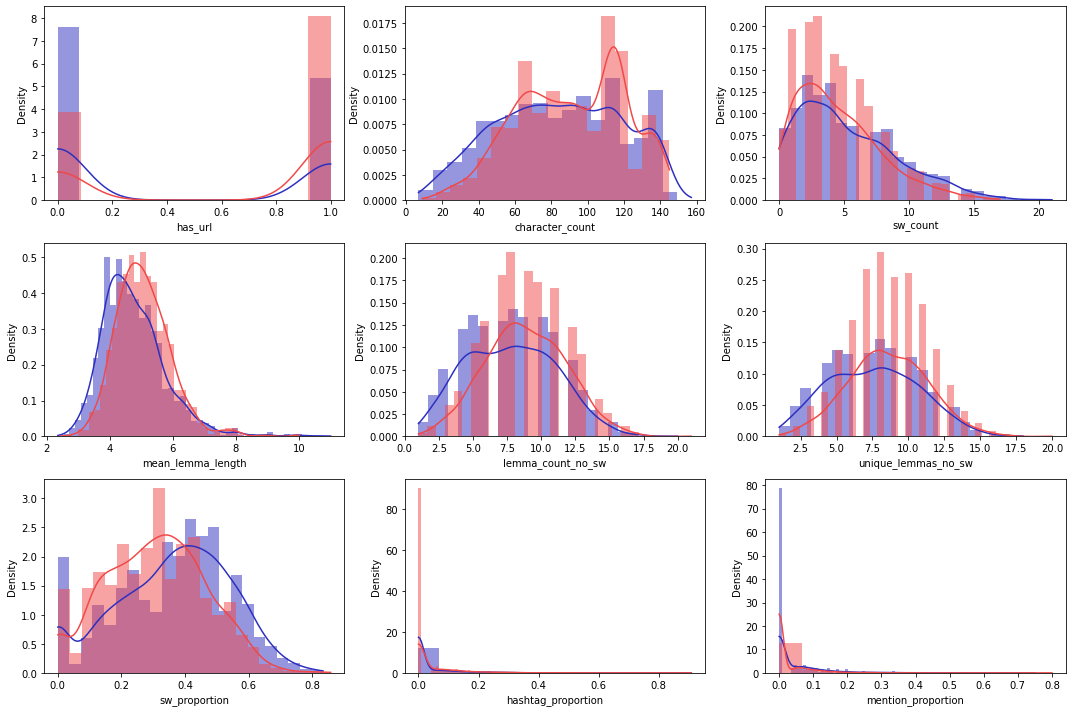

In [65]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,10))
fl_ax = axes.flatten()

for idx, ftr in list(enumerate(meta_features_df_train.columns)):
    sns.histplot(meta_features_df_train[ftr][y_train==0], ax=fl_ax[idx], **kwargs_distplot, color=color_non)
    sns.histplot(meta_features_df_train[ftr][y_train==1], ax=fl_ax[idx], **kwargs_distplot, color=color_disaster)

plt.tight_layout()
plt.show()

# sns.countplot(meta_features_df_train['has_url'][y_train==0], ax=fl_ax[0], color=color_non)
# sns.countplot(meta_features_df_train['has_url'][y_train==1], ax=fl_ax[0], color=color_disaster)

In [66]:
# END VISUALIZING
#
#
# 
# 
# 
# 
# 
#  #

## Vectorizing the tweets

I've engineered linguistic features and meta-features. I'm going to make the actual text of the tweets interpretable by a machine learning model. I'm using scikit-learn's TF-IDF vectorizer and the lemmatized tokens of the tweets.

This vectorizor returns ______________. 

In the same step, I'm going to combine the vectors with the other features I've engineered so far into a single DataFrame. **This is the DataFrame that the model will train on.**

In [91]:
tfidf = TfidfVectorizer(
    tokenizer=spacy_lemmatize, stop_words=stopword_list_lem, max_features=50, 
    binary=True
    )
X_train_vec = tfidf.fit_transform(X_train['text'])
X_train_vec_df = pd.DataFrame(
    X_train_vec.toarray(), columns=tfidf.get_feature_names(), index=X_train.index
    )

X_train_combined_df = pd.concat(
    [
        X_train_vec_df, 
        pos_vectorized_df_train, 
        ner_vectorized_df_train, 
        meta_features_df_train,
    ],
    axis=1
    )

# Test

X_test_vec = tfidf.transform(X_test['text'])
X_test_vec_df = pd.DataFrame(
    X_test_vec.toarray(), columns=tfidf.get_feature_names(), index=X_test.index
)

X_test_combined_df = pd.concat(
    [
        X_test_vec_df, 
        pos_vectorized_df_test, 
        ner_vectorized_df_test, 
        meta_features_df_test,
    ],
    axis=1
    )

# Val

X_val_vec = tfidf.transform(X_val['text'])
X_val_vec_df = pd.DataFrame(
    X_val_vec.toarray(), columns=tfidf.get_feature_names(), index=X_val.index
)

X_val_combined_df = pd.concat(
    [
        X_val_vec_df, 
        pos_vectorized_df_val, 
        ner_vectorized_df_val, 
        meta_features_df_val,
    ],
    axis=1
    )

# Scaling all features

scaler = StandardScaler()
X_train_combined_df_scaled = scaler.fit_transform(X_train_combined_df)
X_train_combined_df_scaled = pd.DataFrame(X_train_combined_df_scaled, index=X_train.index, columns=X_train_combined_df.columns)

X_test_combined_df_scaled = scaler.transform(X_test_combined_df)
X_test_combined_df_scaled = pd.DataFrame(X_test_combined_df_scaled, index=X_test.index, columns=X_test_combined_df.columns)

X_val_combined_df_scaled = scaler.transform(X_val_combined_df)
X_val_combined_df_scaled = pd.DataFrame(X_val_combined_df_scaled, index=X_val.index, columns=X_val_combined_df.columns)

X_train_combined_df_scaled.head()

c:\Users\zshoo\anaconda3\envs\learn-env\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


,attack,bag,body,bomb,building,burn,california,car,cause,come,...,TIME,has_url,character_count,sw_count,mean_lemma_length,lemma_count_no_sw,unique_lemmas_no_sw,sw_proportion,hashtag_proportion,mention_proportion
7250,-0.139029,-0.113093,-0.140957,-0.139559,-0.11789,-0.13567,-0.117656,-0.118316,-0.120759,-0.144834,...,-0.170625,0.949834,-0.658384,-1.081962,0.451311,-0.074281,-0.001094,-1.311649,0.839409,-0.440997
6439,4.874942,-0.113093,-0.140957,-0.139559,-0.11789,-0.13567,-0.117656,-0.118316,-0.120759,-0.144834,...,-0.170625,0.949834,0.955996,0.021510,0.592690,1.169246,1.306316,-0.253237,-0.394316,-0.440997
4885,-0.139029,-0.113093,-0.140957,-0.139559,-0.11789,-0.13567,-0.117656,-0.118316,-0.120759,-0.144834,...,-0.170625,0.949834,0.210897,-0.530226,0.662603,0.547482,0.652611,-0.619610,-0.394316,1.644250
4115,-0.139029,-0.113093,-0.140957,-0.139559,-0.11789,-0.13567,-0.117656,-0.118316,-0.120759,-0.144834,...,-0.170625,0.949834,-0.782567,-1.081962,0.451311,-0.385163,-0.327947,-1.231323,6.545389,-0.440997
575,-0.139029,-0.113093,-0.140957,-0.139559,-0.11789,-0.13567,-0.117656,-0.118316,-0.120759,-0.144834,...,-0.170625,0.949834,0.210897,-0.254358,0.708823,-0.074281,-0.001094,-0.026434,0.530978,0.688512


In [96]:
###########################################################
###########################################################

In [104]:
X_train_combined_df_scaled.shape

(4181, 80)

In [105]:
precision = Precision()
recall = Recall()
auc = AUC()
# f1 ?

model = models.Sequential()

model.add(layer=layers.Dense(
        units=80,
        activation='relu',
        input_shape=(X_train_combined_df_scaled.shape[1],)
    ))

model.add(layer=layers.Dense(
    units=60,
    activation='relu',
))

model.add(layer=layers.Dense(
    units=10,
    activation='relu',
))

model.add(layer=layers.Dense(
    units=1,
    activation='sigmoid',
))

model.compile(
    optimizer='SGD',
    loss='binary_crossentropy',
    metrics=['accuracy', precision, recall, auc]
)

model_val = model.fit(
    np.array(X_train_combined_df_scaled),
    np.array(y_train),
    epochs=100,
    batch_size=32,
    validation_data=(X_val_combined_df_scaled, y_val)
)

Epoch 1/100
131/131 [==============================] - 1s 7ms/step - loss: 0.6841 - accuracy: 0.5587 - precision_8: 0.4816 - recall_8: 0.4398 - auc_8: 0.5765 - val_loss: 0.6506 - val_accuracy: 0.6442 - val_precision_8: 0.6328 - val_recall_8: 0.4484 - val_auc_8: 0.6635
Epoch 2/100
131/131 [==============================] - 0s 2ms/step - loss: 0.6364 - accuracy: 0.6506 - precision_8: 0.6334 - recall_8: 0.4308 - auc_8: 0.6805 - val_loss: 0.6185 - val_accuracy: 0.6793 - val_precision_8: 0.6830 - val_recall_8: 0.5008 - val_auc_8: 0.7221
Epoch 3/100
131/131 [==============================] - 0s 2ms/step - loss: 0.6077 - accuracy: 0.6862 - precision_8: 0.6840 - recall_8: 0.4924 - auc_8: 0.7256 - val_loss: 0.5961 - val_accuracy: 0.7059 - val_precision_8: 0.7089 - val_recall_8: 0.5581 - val_auc_8: 0.7480
Epoch 4/100
131/131 [==============================] - 0s 2ms/step - loss: 0.5863 - accuracy: 0.7001 - precision_8: 0.7010 - recall_8: 0.5188 - auc_8: 0.7490 - val_loss: 0.5812 - val_accuracy: 

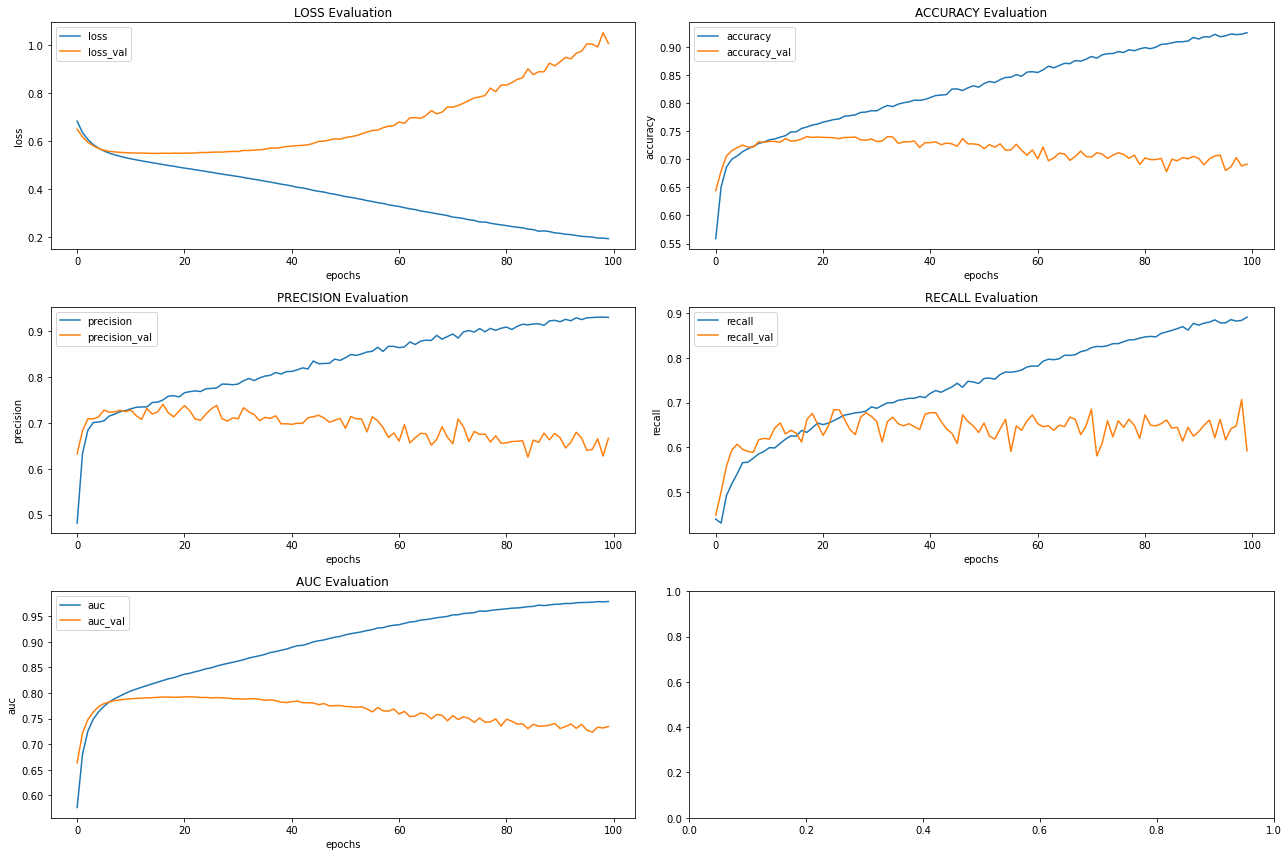

In [106]:
# Visualizing NN

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18,12))
fl_ax = axes.flatten()
for idx, metric in enumerate(['loss', 'accuracy', 'precision', 'recall', 'auc']):
    pair = [m for m in model_val.history.keys() if metric in m]
    fl_ax[idx].plot(model_val.history[pair[0]], label=metric)
    fl_ax[idx].plot(model_val.history[pair[1]], label=metric+'_val')
    fl_ax[idx].set_xlabel('epochs')
    fl_ax[idx].set_ylabel(metric)
    fl_ax[idx].set_title(f'{metric.upper()} Evaluation')
    fl_ax[idx].legend()
    plt.tight_layout();

In [103]:
##############################################
##############################################

In [107]:
some_model = RandomForestClassifier()
cross_val_score(some_model, X_train_combined_df_scaled, y_train, cv=5, scoring='recall')

array([0.53221289, 0.59943978, 0.58823529, 0.59943978, 0.55462185])

In [108]:
some_model.fit(X_train_combined_df_scaled, y_train)

RandomForestClassifier()

In [109]:
sorted(list(zip(X_train_combined_df_scaled.columns, some_model.feature_importances_.tolist())), key=lambda x: x[1], reverse=True)

[('mean_lemma_length', 0.0844794642889291),
 ('character_count', 0.0767787185262907),
 ('sw_proportion', 0.059331243575906474),
 ('NOUN', 0.04385751163298538),
 ('unique_lemmas_no_sw', 0.042790150652474906),
 ('lemma_count_no_sw', 0.042679785900964703),
 ('sw_count', 0.038080333361380406),
 ('ADP', 0.03739118170935731),
 ('PROPN', 0.03569268385657692),
 ('PRON', 0.03381311893957986),
 ('mention_proportion', 0.0314525373386702),
 ('has_url', 0.03119387470694681),
 ('VERB', 0.03057972503158465),
 ('ADJ', 0.028309367640846555),
 ('hashtag_proportion', 0.027992095172147815),
 ('GPE', 0.025148221865103536),
 ('AUX', 0.02141614574362326),
 ('DET', 0.02069131762225124),
 ('ADV', 0.019875844850716723),
 ('PART', 0.015814151341010396),
 ('fire', 0.014663048856978299),
 ('CCONJ', 0.014062163098131752),
 ('SCONJ', 0.012007797527231317),
 ('ORG', 0.008902769199929496),
 ('kill', 0.008337320732938448),
 ('like', 0.008145341345007983),
 ('NORP', 0.007103302950464423),
 ('INTJ', 0.006309683009404069)

In [77]:
# Total time:
t = time.time() - start_time
print(f'Notebook run time: {t//60:.0f} minutes and {t%60:.0f} seconds')

Notebook run time: 8 minutes and 11 seconds
